In [19]:
import pyterrier as pt
import os
import numpy as np
import pandas as pd
import fastrank
import requests
import datetime

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [20]:
if not pt.started():
    pt.init()

## Downloading the trec covid dataset

In [21]:
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './indices/cord19'

if not os.path.exists(pt_index_path + "/data.properties"):
    indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)
    index_ref = indexer.index(dataset.get_corpus_iter(), 
                            fields=['title', 'doi', 'abstract'], 
                            meta=('docno',))
else:
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")

In [22]:
metadata = pd.read_csv('~/.ir_datasets/cord19/2020-07-16/metadata.csv')

/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
index = pt.IndexFactory.of(index_ref)
topics = dataset.get_topics('title')
qrels = dataset.get_qrels()

In [24]:
qrels

,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4
...,...,...,...,...
69313,50,zvop8bxh,2,5
69314,50,zwf26o63,1,5
69315,50,zwsvlnwe,0,5
69316,50,zxr01yln,1,5


In [25]:
len(metadata['journal'].unique())

18112

### How do pipes work

We set up a two-stage ranking pipeline with a BM25 first stage ranker whose outputs will be reranked by a ML method given the predefined featues.

In [26]:
BM25 = pt.BatchRetrieve(index, controls={"wmodel": "BM25"})
TF_IDF = pt.BatchRetrieve(index, controls = {"wmodel":"TF_IDF"})
PL2 = pt.BatchRetrieve(index, controls = {"wmodel": "PL2"})

We make a pipe by transforming the BM25 outputs with the help of PL2 and TFIDF

In [27]:
pipe = BM25 >>(TF_IDF ** PL2)

Alternative: FeatureBatchRetrieve object

In [28]:
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:TF_IDF", "WMODEL:PL2"]) 
(fbr % 5).search("coronavirus immunity")

,qid,query,docid,rank,features,docno,score
0,1,coronavirus immunity,187945,0,"[4.540221677858543, 3.477440707307063]",sp212tai,10.118259
1,1,coronavirus immunity,126990,1,"[4.377525236902022, 3.3080236155861185]",e1mw9lx1,10.001470
2,1,coronavirus immunity,179948,2,"[4.559628851404359, 3.5124279884117215]",ltmuw6f8,9.974369
3,1,coronavirus immunity,156456,3,"[4.600248221319108, 3.649953983552013]",1oruu33o,9.955978
4,1,coronavirus immunity,94922,4,"[4.490926556339275, 3.312256733881456]",5jl6ltfj,9.734640


### LTR

Split into train test using cross validation

In [29]:
train_topics, validation_topics, test_topics = np.split(topics, [int(.6*len(topics)), int(.8*len(topics))])

In [30]:
train_min = train_topics['qid'].astype(int).min()
train_max = train_topics['qid'].astype(int).max()
train_qrels = qrels[(qrels['qid'].astype(int) >= train_min) & (qrels['qid'].astype(int) <= train_max)]

val_min = validation_topics['qid'].astype(int).min()
val_max = validation_topics['qid'].astype(int).max()
validation_qrels = qrels[(qrels['qid'].astype(int) >= val_min) & (qrels['qid'].astype(int) <= val_max)]

test_min = test_topics['qid'].astype(int).min()
test_max = test_topics['qid'].astype(int).max()
test_qrels = qrels[(qrels['qid'].astype(int) >= test_min) & (qrels['qid'].astype(int) <= test_max)]

# How well do the algorithm work without any features?

Following, the five testes ranking algorithms will be put to the test. We are using the PL2 algorithm as a baseline and compare it to LambdaMart, LightGBM, Random Forest, FastRank with Gradient Ascent and FastRank with Random Forest.

In [31]:
pl2 = pt.BatchRetrieve(index, wmodel="PL2")
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:BM25"])


In [32]:
lmart_x = xgb.sklearn.XGBRanker(objective='rank:ndcg',
      learning_rate=0.1,
      gamma=1.0,
      min_child_weight=0.1,
      max_depth=6,
      verbose=2,
      random_state=42,
      num_round =  10)

In [33]:
train_request = fastrank.TrainRequest.coordinate_ascent()
params = train_request.params
train_request.measure = 'ndcg'
params.init_random = True
params.normalize = True
params.seed = 1234567

In [34]:
train_request_forest = fastrank.TrainRequest.random_forest()
params = train_request_forest.params
train_request_forest.measure = 'ndcg'
params.num_trees = 10
params.feature_sampling_rate = 0.5
params.instance_sampling_rate = 0.5
params.seed = 1234567

In [35]:
rf = RandomForestRegressor(n_estimators= 300)
rf_pipe = fbr >> pt.ltr.apply_learned_model(rf)

In [36]:
lmart_x_pipe = fbr >> pt.ltr.apply_learned_model(lmart_x, form="ltr")
lmart_x_pipe.fit(train_topics, train_qrels, validation_topics, validation_qrels)

rf_pipe = fbr >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, qrels)

ca_pipe = fbr >> pt.ltr.apply_learned_model(train_request, form="fastrank")
ca_pipe.fit(train_topics, qrels)

fr_rf_pipe = fbr >> pt.ltr.apply_learned_model(train_request_forest, form="fastrank")
fr_rf_pipe.fit(train_topics, qrels)

[12:41:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #2/5...
[+] Random restart #3/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
-----------------

In [37]:
results = pt.Experiment([PL2, BM25, lmart_x_pipe, rf_pipe, ca_pipe, fr_rf_pipe], test_topics, qrels, ["ndcg", "map"], 
                        names=["PL2 (Baseline)", "BM25 (base ranker)", "LMART", "Random Forest", "Fastrank Coordinate Ascend", "Fastrank Random Forest"], baseline = 0, filter_by_topics = True)

In [38]:
results

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LMART,0.166378,0.436964,0.0,10.0,0.005058,1.0,9.0,0.004475
3,Random Forest,0.147969,0.423103,0.0,10.0,0.003030,1.0,9.0,0.002798
4,Fastrank Coordinate Ascend,0.283973,0.519278,1.0,9.0,0.042773,2.0,8.0,0.471011
5,Fastrank Random Forest,0.154931,0.424146,0.0,10.0,0.001263,1.0,9.0,0.000867


## Applying recency boost

In [39]:
metadata['publish_year'] = pd.to_datetime(metadata['publish_time'])
metadata['publish_year'] = metadata['publish_year'].dt.strftime('%Y')
metadata['publish_year'] = metadata['publish_year'].fillna(0)
metadata['publish_year'] = metadata['publish_year'].astype(str).astype(int)

metadata['publish_year_feature'] = 0

metadata.loc[metadata['publish_year'] < 2019, 'publish_year_feature'] = 1
metadata.loc[metadata['publish_year'] == 2019, 'publish_year_feature'] = 2
metadata.loc[metadata['publish_year'] >= 2020, 'publish_year_feature'] = 3


In [40]:
date_dict = {}

for id, dates in zip(metadata['cord_uid'], metadata['publish_year_feature']):
    date_dict[id] = dates


## Applying Journal impact

In [41]:
journal_impact = pd.read_csv('./data/scimagojr 2020.csv', sep = ';', header = None)
journal_abbrev = pd.read_csv('./data/wos_abbrev_table.csv', sep = ';', header = None)
journal_impact=journal_impact.T.set_index(0).T
journal_abbrev=journal_abbrev.T.set_index(0).T
journal_abbrev = journal_abbrev[['full', 'abbrev']]

/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,5,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
journal_impact = journal_impact[['Title', 'SJR', 'H index']]

In [43]:
journals = metadata[['cord_uid','journal']]
journals = journals.drop_duplicates()
journals = pd.DataFrame(journals)

In [44]:
journals['journal'] = journals['journal'].str.lower()
journal_impact['Title'] = journal_impact['Title'].str.lower()
journal_abbrev['full'] = journal_abbrev['full'].str.lower()
journal_abbrev['abbrev'] = journal_abbrev['abbrev'].str.lower()

In [45]:
journals = pd.merge(journals, journal_abbrev, left_on='journal', right_on='abbrev', how='left')

In [46]:
journals = journals[['cord_uid', 'journal', 'full', 'abbrev']]
journals['full'] = journals['full'].fillna(journals['journal'])
journals['abbrev'] = journals['abbrev'].fillna(journals['journal'])

In [47]:
journals

,cord_uid,journal,full,abbrev
0,ug7v899j,bmc infect dis,bmc infectious diseases,bmc infect dis
1,02tnwd4m,respir res,respiratory research,respir res
2,ejv2xln0,respir res,respiratory research,respir res
3,2b73a28n,respir res,respiratory research,respir res
4,9785vg6d,respir res,respiratory research,respir res
...,...,...,...,...
217298,z4ro6lmh,infection,infection,infection
217299,hi8k8wvb,physica b: condensed matter,physica b: condensed matter,physica b: condensed matter
217300,ma3ndg41,catheter cardiovasc interv,catheter cardiovasc interv,catheter cardiovasc interv
217301,wh10285j,ann surg,annals of surgery,ann surg


In [48]:
journals['cord_uid'] = journals['cord_uid'].drop_duplicates()

In [49]:
metadata_journals = pd.merge(metadata, journals , left_on='cord_uid', right_on='cord_uid', how='left')

In [50]:
metadata_journals = metadata_journals.merge(journal_impact, how = 'left', left_on = "full", right_on = "Title")

In [51]:
#merged = metadata.merge(journal_impact, how = 'left', left_on = "journal", right_on = "Title")
metadata_journals['H index'] = [float(str(i).replace(",", "")) for i in metadata_journals['H index']]
#merged['H index'] = merged['H index'].fillna(merged['H index'].mean())
#merged['norm_H_index']=(merged['H index']-merged['H index'].min())/(merged['H index'].max()-merged['H index'].min())

In [52]:
metadata_journals['H index'] = [float(str(i).replace(",", "")) for i in metadata_journals['H index']]
metadata_journals = metadata_journals.rename(columns={"H index": "H_index"})

In [53]:
metadata_journals['SJR'] = [float(str(i).replace(",", "")) for i in metadata_journals['SJR']]


In [54]:
metadata_journals['H_index'].describe()

count    88969.000000
mean       170.107476
std        189.732422
min          0.000000
25%         70.000000
50%        116.000000
75%        205.000000
max       1276.000000
Name: H_index, dtype: float64

In [55]:
lower = metadata_journals['H_index'].describe()[4]
middle = metadata_journals['H_index'].describe()[5]
upper = metadata_journals['H_index'].describe()[6]

In [56]:
lower, middle, upper

(70.0, 116.0, 205.0)

In [57]:
metadata_journals['H_index'].fillna(value = lower, inplace = True)

metadata_journals['H_index'].loc[metadata_journals['H_index'] < lower] = 1
metadata_journals['H_index'].loc[metadata_journals['H_index'] == lower] = 1.5
metadata_journals.loc[metadata_journals['H_index'].between(lower, middle), 'H_index'] = 2
metadata_journals.loc[metadata_journals['H_index'].between(middle,upper), 'H_index'] = 3
metadata_journals.loc[metadata_journals['H_index'].between(upper, 1276), 'H_index'] = 4

/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [58]:
metadata_journals['SJR'].describe()

count    88407.000000
mean      2106.080457
std       3092.592827
min        100.000000
25%        751.000000
50%       1175.000000
75%       2134.000000
max      37461.000000
Name: SJR, dtype: float64

In [59]:
lower = metadata_journals['SJR'].describe()[4]
middle = metadata_journals['SJR'].describe()[5]
upper = metadata_journals['SJR'].describe()[6]

In [60]:
lower, middle, upper

(751.0, 1175.0, 2134.0)

In [61]:
metadata_journals['SJR'].fillna(value = lower, inplace = True)

metadata_journals['SJR'].loc[metadata_journals['SJR'] < lower] = 1
metadata_journals['SJR'].loc[metadata_journals['SJR'] == lower] = 1.5
metadata_journals.loc[metadata_journals['SJR'].between(lower, middle), 'SJR'] = 2
metadata_journals.loc[metadata_journals['SJR'].between(middle,upper), 'SJR'] = 3
metadata_journals.loc[metadata_journals['SJR'].between(upper, 37461), 'SJR'] = 4

In [62]:
metadata_journals['H_index'].describe()

count    192847.000000
mean          1.961656
std           0.906074
min           1.000000
25%           1.500000
50%           1.500000
75%           2.000000
max           4.000000
Name: H_index, dtype: float64

In [63]:
metadata_journals['SJR'].describe()

count    192847.000000
mean          1.955937
std           0.904294
min           1.000000
25%           1.500000
50%           1.500000
75%           2.000000
max           4.000000
Name: SJR, dtype: float64

In [64]:
sjr_dict = {}
h_dict = {}

for id, sjr in zip(metadata_journals['cord_uid'], metadata_journals['SJR']):
    sjr_dict[id] = sjr

for id, h_id in zip(metadata_journals['cord_uid'], metadata_journals['H_index']):
    h_dict[id] = h_id


The SJR and H index helped Fastrank however not LMAR or RF. Generally, about 88000 columns have an associated journal ranking now. The others are 

## Citation rank

# Applying the topic cites to all qrels

In [65]:
def get_cites(input_df):
    df = input_df
    # merge the fbr (pooled documents) with our metadata and remove duplicates to minimize API calls
    df = input_df.merge(metadata, left_on = "docno", right_on = "cord_uid", how = "left") 
    df = df[['qid', 'docno', 'label', 'iteration', 'cord_uid', 'title', 'doi',
                    'abstract', 'publish_time', 'authors', 'journal']]
    #fbr_meta = fbr_meta.drop_duplicates(subset='doi', keep="first")
    #fbr_meta = fbr_meta.drop_duplicates(subset='title', keep="first")
    df = df.reset_index()
    df = df.drop(columns = 'index')
    #fbr_meta.update('"' + fbr_meta[['title']].astype(str) + '"')
    df = df.drop_duplicates(subset='title', keep="first")

    cites_df = pd.DataFrame()
    for i in range(len(df)):
        try:
            title_information = requests.get(
                'https://api.openalex.org/works?filter=title.search:'+df['title'][i]
                ).json()['results'][0]
            current_title = pd.DataFrame.from_dict(title_information, orient='index')
            current_title = current_title.transpose()
            cites_df = cites_df.append(current_title)
            print("Request number:", i)
        # in case DOI and title is missing, no information is printed
        except:
            try:
                doi_information = requests.get(
                    'https://api.openalex.org/works?filter=doi:https://doi.org/'+df['doi'][i]
                    ).json()['results'][0]
                    #print('Retrieved:',fbr_meta['doi'][i])
                    # append the current document information to our main dataframe
                current_doi = pd.DataFrame.from_dict(doi_information, orient='index')
                current_doi = current_doi.transpose()
                cites_df = cites_df.append(current_doi)
                print("Request number:", i)
            except:
                print("No title or doi information on OpenAlex found")
    # finally, we are merging our OpenAlex data with our fbr and meta data by merging over the doi
    cites_df = cites_df[['doi', 'title', 'referenced_works', 'related_works', 'cited_by_count', 'counts_by_year']]
    cites_df = cites_df.reset_index()
    cites_df = cites_df.drop(columns = 'index')
    cites_df['doi'] = cites_df.doi.str.replace('https://doi.org/', '')
    #fbr_meta_cites = fbr_meta.merge(cites_df, left_on = 'title', right_on = 'title')
    return cites_df

In [66]:
qrels['docno'].drop_duplicates(keep="first")

0        005b2j4b
1        00fmeepz
2        010vptx3
3        0194oljo
4        021q9884
           ...   
69305    zn10rnrm
69308    zstmdt4n
69310    zth8ffy3
69312    zv4nbz9p
69313    zvop8bxh
Name: docno, Length: 37924, dtype: object

In [67]:
# creating the main cites dataframe
cites_df1 = pd.read_csv('../WIR-Project/data/cites_df1.csv')
cites_df2 = pd.read_csv('../WIR-Project/data/cites_df2.csv')
cites_df3 = pd.read_csv('../WIR-Project/data/cites_df3.csv')
cites_df4 = pd.read_csv('../WIR-Project/data/cites_df4.csv')

cites_df = cites_df1.append(cites_df2)
cites_df = cites_df.append(cites_df3)
cites_df = cites_df.append(cites_df4)
qrels = dataset.get_qrels()

In [68]:
# preprocessing the title to lowercase and merging the data
cites_df['title'] = cites_df['title'].str.lower()

meta = metadata
meta['title'] = meta['title'].str.lower()

meta_cites = cites_df.merge(meta, left_on = 'title', right_on = 'title', how = 'right')
meta_cites = meta_cites[['cited_by_count', 'cord_uid']]
meta_cites = meta_cites.rename(columns={"cord_uid": "docno"})

In [69]:
# Adding an indexer to the qrels. The merges create about 500 duplicated values which can not be deleted otherwise
qrels = qrels.reset_index()
qrels = qrels.rename(columns={"index":"indexer"})

In [70]:
qrels

,indexer,qid,docno,label,iteration
0,0,1,005b2j4b,2,4.5
1,1,1,00fmeepz,1,4
2,2,1,010vptx3,2,0.5
3,3,1,0194oljo,1,2.5
4,4,1,021q9884,1,4
...,...,...,...,...,...
69313,69313,50,zvop8bxh,2,5
69314,69314,50,zwf26o63,1,5
69315,69315,50,zwsvlnwe,0,5
69316,69316,50,zxr01yln,1,5


In [71]:
meta_cites = meta_cites.drop_duplicates()
merged_df = pd.merge(qrels, meta_cites, on='docno', how='left', indicator=True)

merged_df = merged_df.drop_duplicates(subset='indexer', keep="first")
merged_df = merged_df.reset_index()
merged_df = merged_df.drop(columns = 'index')

qrels = qrels.drop(columns=['indexer'])
result = qrels.eq(merged_df[['qid', 'docno', 'label', 'iteration']], axis='index')
result = result.all(axis=1)

In [72]:
# check if the dataframes are actually completely identical

a = merged_df[['qid', 'docno', 'label', 'iteration']]
b = qrels

if a.equals(b):
    print("The DataFrames are identical.")
else:
    print("The DataFrames are not identical.")

The DataFrames are identical.


In total 48306 of 69318 qrels are associated with their citations

In [73]:
merged_df['cited_by_count'].describe()

count    48306.000000
mean       169.759926
std        757.097184
min          0.000000
25%         11.000000
50%         35.000000
75%        111.000000
max      30662.000000
Name: cited_by_count, dtype: float64

In [74]:
# assigning the features impact

lower = merged_df['cited_by_count'].describe()[4]
middle = merged_df['cited_by_count'].describe()[5]
upper = merged_df['cited_by_count'].describe()[6]

merged_df['cited_by_count'] = merged_df['cited_by_count'].fillna(value=lower)
merged_df['cited_by_count'].loc[merged_df['cited_by_count'] < lower] = 1
merged_df.loc[merged_df['cited_by_count'].between(lower, middle), 'cited_by_count'] = 2
merged_df.loc[merged_df['cited_by_count'].between(middle, upper), 'cited_by_count'] = 3
merged_df['cited_by_count'].loc[merged_df['cited_by_count'] > upper] = 4

/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [75]:
# finally, we have to merge it again with the metadata, since some docno actually do not appear in the qrels. This is weird however, should be the minority. Other documents have the cited by count 0
docno_cites = merged_df[['docno', 'cited_by_count']]
full_data = meta.merge(docno_cites, left_on= "cord_uid", right_on = "docno", how = "outer")
full_data['cited_by_count'] = full_data['cited_by_count'].fillna(value= 0)

In [76]:
citation_dic = {}

for id, cites in zip(full_data['cord_uid'], full_data['cited_by_count']):
    citation_dic[id] = cites

# Final functions to choose which features to include in the reranking procedure

In [77]:
def dates(docno):
    raw_dates = date_dict[docno]
    return raw_dates

def sjr(docno):
    raw_sjr = sjr_dict[docno]
    return raw_sjr

def h_idx(docno):
    raw_h_idx = h_dict[docno]
    return raw_h_idx

def cites(docno):
    raw_cites = citation_dic[docno]
    return raw_cites

In [78]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f1, f2, f3, f4]))
    return features

In [79]:
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:BM25"]) 
fbr >> pt.apply.doc_features(_features)

p = fbr >> pt.apply.doc_features(_features)

p.transform("coronavirus origin")

/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/pyterrier/ops.py:331: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  topics = m.transform(topics)


,qid,query,docid,rank,features,docno,score
0,1,coronavirus origin,122804,0,"[7.243034202814337, 3.0, 1.5, 1.5, 3.0]",75773gwg,11.578681
1,1,coronavirus origin,122805,1,"[7.252674838560409, 3.0, 1.5, 1.5, 3.0]",kn2z7lho,11.578681
2,1,coronavirus origin,122806,2,"[7.256040044023486, 3.0, 1.5, 1.5, 3.0]",4fb291hq,11.578681
3,1,coronavirus origin,135326,3,"[7.256040044023486, 1.0, 4.0, 4.0, 4.0]",ne5r4d4b,11.452880
4,1,coronavirus origin,187888,4,"[7.267153309588337, 3.0, 1.5, 1.5, 3.0]",hl967ekh,11.428047
...,...,...,...,...,...,...,...
995,1,coronavirus origin,186498,995,"[8.965273511062476, 3.0, 2.0, 2.0, 4.0]",w8cvq0m5,7.256041
996,1,coronavirus origin,10395,996,"[9.358174003925521, 1.0, 3.0, 1.5, 2.0]",l8a7lzhb,7.256040
997,1,coronavirus origin,134989,997,"[7.81745407521776, 1.0, 2.0, 3.0, 0.0]",nh06fp82,7.256040
998,1,coronavirus origin,73423,998,"[8.711893939558887, 3.0, 1.5, 1.5, 2.0]",i758v1vb,7.252675


In [80]:
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:BM25"]) 
fbr >> pt.apply.doc_features(_features)

lmart_x_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(lmart_x, form="ltr")
lmart_x_pipe.fit(train_topics, train_qrels, validation_topics, validation_qrels)

rf_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, qrels)

ca_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(train_request, form="fastrank")
ca_pipe.fit(train_topics, qrels)

fr_rf_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(train_request_forest, form="fastrank")
fr_rf_pipe.fit(train_topics, qrels)

results = pt.Experiment([PL2, BM25, lmart_x_pipe, rf_pipe, ca_pipe, fr_rf_pipe], test_topics, qrels, ["ndcg", "map"], 
            names=["PL2 (Baseline)", "BM25 (base ranker)", "LambdaMART", "Random Forest", "Fastrank Coordinate Ascend", "Fastrank Random Forest"], baseline = 0, filter_by_topics = True)

results

[12:44:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
[+] Random restart #2/5...
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
-----------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.268962,0.493576,5.0,5.0,0.293422,3.0,7.0,0.203719
3,Random Forest,0.283416,0.504118,4.0,6.0,0.281881,3.0,7.0,0.175712
4,Fastrank Coordinate Ascend,0.317779,0.524103,5.0,5.0,0.870692,6.0,4.0,0.980522
5,Fastrank Random Forest,0.253856,0.481419,4.0,6.0,0.230622,4.0,6.0,0.135901


# Computing the feature importance

In [81]:
fnames = ["BM25", "Recency", "SJR", "H-Index", "Citations"]

/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_13575/376710058.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


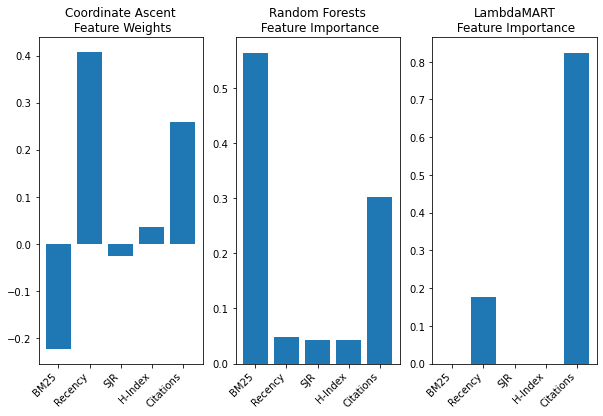

In [82]:
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_x.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("LambdaMART\n Feature Importance")

fig.show()


# Final results summary:

In [97]:
def train_models():
    fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:BM25"]) 
    fbr >> pt.apply.doc_features(_features)

    lmart_x_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(lmart_x, form="ltr")
    lmart_x_pipe.fit(train_topics, train_qrels, validation_topics, validation_qrels)

    rf_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(rf)
    rf_pipe.fit(train_topics, qrels)

    ca_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(train_request, form="fastrank")
    ca_pipe.fit(train_topics, qrels)

    fr_rf_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(train_request_forest, form="fastrank")
    fr_rf_pipe.fit(train_topics, qrels)

    results = pt.Experiment([PL2, BM25, lmart_x_pipe, rf_pipe, ca_pipe, fr_rf_pipe], test_topics, qrels, ["ndcg", "map"], 
                        names=["PL2 (Baseline)", "BM25 (base ranker)", "LambdaMART", "Random Forest", "Fastrank Coordinate Ascend", "Fastrank Random Forest"], baseline = 0, filter_by_topics = True)
    return(results)

# Results using the recency ranking

In [84]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f1]))
    return features

In [85]:
results = train_models()
results

[12:47:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #4/5...
[+] Random restart #2/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
-----------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.168598,0.445947,2.0,8.0,0.012282,2.0,8.0,0.014904
3,Random Forest,0.176365,0.446995,0.0,10.0,0.006275,1.0,9.0,0.011411
4,Fastrank Coordinate Ascend,0.321934,0.539068,5.0,5.0,0.456311,6.0,4.0,0.068947
5,Fastrank Random Forest,0.197146,0.451229,0.0,10.0,0.001746,1.0,9.0,0.001036


# Results using the recency ranking and citation ranking

In [89]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f1, f4]))
    return features

In [90]:
results = train_models()
results

[13:13:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
-----------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.268962,0.493576,5.0,5.0,0.293422,3.0,7.0,0.203719
3,Random Forest,0.284330,0.501717,4.0,6.0,0.287900,3.0,7.0,0.200475
4,Fastrank Coordinate Ascend,0.323965,0.530233,5.0,5.0,0.657003,6.0,4.0,0.631138
5,Fastrank Random Forest,0.243468,0.471134,3.0,7.0,0.111819,2.0,8.0,0.036200


# Results using the journal ranking and citations ranking:

In [91]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f2, f3, f4]))
    return features

In [92]:
results = train_models()
results

[13:16:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
-----------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.240453,0.476597,4.0,6.0,0.119070,3.0,7.0,0.070523
3,Random Forest,0.261618,0.491862,2.0,8.0,0.124396,2.0,8.0,0.104795
4,Fastrank Coordinate Ascend,0.299891,0.515166,4.0,6.0,0.607704,6.0,4.0,0.549257
5,Fastrank Random Forest,0.230545,0.461231,2.0,8.0,0.086621,3.0,7.0,0.029653


# Results using all features:

In [93]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f1, f2, f3, f4]))
    return features

In [94]:
results = train_models()
results

[13:19:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
-----------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.268962,0.493576,5.0,5.0,0.293422,3.0,7.0,0.203719
3,Random Forest,0.283615,0.500831,4.0,6.0,0.283794,3.0,7.0,0.133798
4,Fastrank Coordinate Ascend,0.317779,0.524103,5.0,5.0,0.870692,6.0,4.0,0.980522
5,Fastrank Random Forest,0.253856,0.481419,4.0,6.0,0.230622,4.0,6.0,0.135901


# Results using only the citation ranking:

In [98]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f4]))
    return features

In [99]:
results = train_models()
results

[13:37:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #4/5...
[+] Random restart #2/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
-----------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.240453,0.476597,4.0,6.0,0.119070,3.0,7.0,0.070523
3,Random Forest,0.253778,0.484860,2.0,8.0,0.094640,2.0,8.0,0.062503
4,Fastrank Coordinate Ascend,0.300818,0.517634,4.0,6.0,0.632396,4.0,6.0,0.672087
5,Fastrank Random Forest,0.256256,0.475840,2.0,8.0,0.080719,1.0,9.0,0.018443


# Using Journal rankings only

In [100]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f2, f3]))
    return features

In [101]:
results = train_models()
results

[13:40:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
-----------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.166378,0.436964,0.0,10.0,0.005058,1.0,9.0,0.004475
3,Random Forest,0.156414,0.429865,0.0,10.0,0.003596,1.0,9.0,0.003858
4,Fastrank Coordinate Ascend,0.281949,0.514405,1.0,9.0,0.032475,2.0,8.0,0.243208
5,Fastrank Random Forest,0.159306,0.425142,0.0,10.0,0.003086,1.0,9.0,0.002276


# Creating a Knowledge Graph out of topic 1: Coronavirus Origin

In [ ]:
df = pd.DataFrame(qrels)

In [ ]:
df = df[df['qid'] == '1']
merged = pd.merge(df, metadata, how = 'left', left_on = 'docno', right_on='cord_uid')
merged = merged[['title', 'source_x']]

In [ ]:
topic_df = pd.DataFrame()
#for i in range(0, len(merged)):
    try:
        title_information = requests.get(
           'https://api.openalex.org/works?filter=title.search:'+merged['title'][i]
            ).json()['results'][0]
        current_title = pd.DataFrame.from_dict(title_information, orient='index')
        current_title = current_title.transpose()
        topic_df = topic_df.append(current_title)
        print(i)
    except:
        print("No title found")

IndentationError: unexpected indent (1801799540.py, line 3)

In [ ]:
topic_df = topic_df[['title', 'publication_year', 'concepts']]
for i in range(len(topic_df)):
    try:
        topic_df.iloc[i, topic_df.columns.get_loc('concepts')] = topic_df.iloc[i]['concepts'][0]['display_name']
    except:
        topic_df.iloc[i, topic_df.columns.get_loc('concepts')] = "Unknown"

/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
topic_df = topic_df.reset_index(drop=True)


In [ ]:
topic_df = topic_df.reset_index(drop=True)
topic_df.to_csv(r'../WIR-Project/data/graph.csv', index=False, header=True) 